In [1]:
%matplotlib inline


# Optical Flow: Predicting movement with the RAFT model

Optical flow is the task of predicting movement between two images, usually two
consecutive frames of a video. Optical flow models take two images as input, and
predict a flow: the flow indicates the displacement of every single pixel in the
first image, and maps it to its corresponding pixel in the second image. Flows
are (2, H, W)-dimensional tensors, where the first axis corresponds to the
predicted horizontal and vertical displacements.

The following example illustrates how torchvision can be used to predict flows
using our implementation of the RAFT model. We will also see how to convert the
predicted flows to RGB images for visualization.


In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

## Reading Videos Using Torchvision
We will first read a video using :func:`~torchvision.io.read_video`.
Alternatively one can use the new :class:`~torchvision.io.VideoReader` API (if
torchvision is built from source).
The video we will use here is free of use from [pexels.com](https://www.pexels.com/video/a-man-playing-a-game-of-basketball-5192157/),
credits go to [Pavel Danilyuk](https://www.pexels.com/@pavel-danilyuk).



In [3]:
# # Import necessary libraries
# import torch
# from PIL import Image
# import torchvision.transforms as transforms

# # Read a PIL image
# image1 = Image.open('C:/Users/Misha/Desktop/1.png')
# image2 = Image.open('C:/Users/Misha/Desktop/2.png')


# # Define a transform to convert PIL
# # image to a Torch tensor
# transform = transforms.Compose([
# 	transforms.PILToTensor()
# ])

# # transform = transforms.PILToTensor()
# # Convert the PIL image to Torch tensor
# img1_tensor = transform(image1)
# img2_tensor = transform(image2)

# # print the converted Torch tensor
# plot(img1_tensor)
# img1_tensor.shape


In [3]:
# Import required libraries
import torch
import cv2
import torchvision.transforms as transforms
from torch import from_numpy
from PIL import Image
import skimage

# Read the image
image1 = Image.open('C:/Users/Misha/Desktop/p/1.png')
image2 = Image.open('C:/Users/Misha/Desktop/p/3.png')

# Convert BGR image to RGB image
# image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
# image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

print(type(image1))

# Define a transform to convert
# the image to torch tensor
transform = transforms.Compose([
	transforms.ToTensor()
])

# Convert the image to Torch tensor
tensor1 = transform(image1)
tensor2 = transform(image2)

# print the converted image tensor
print(tensor1)



<class 'PIL.PngImagePlugin.PngImageFile'>
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1.,

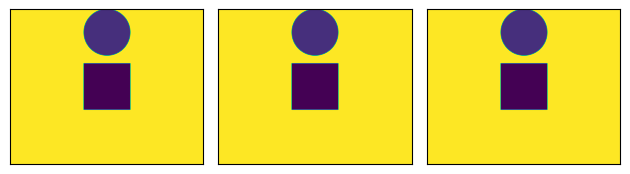

In [13]:
plot(tensor1[0:3,:,:])

In [14]:
from torchvision.io import read_video
# frames, _, _ = read_video(str(video_path), output_format="TCHW")

img1_batch = torch.stack([tensor1[:3, :,:]])
img2_batch = torch.stack([tensor2[:3,:,:]])

# plot(img1_batch)

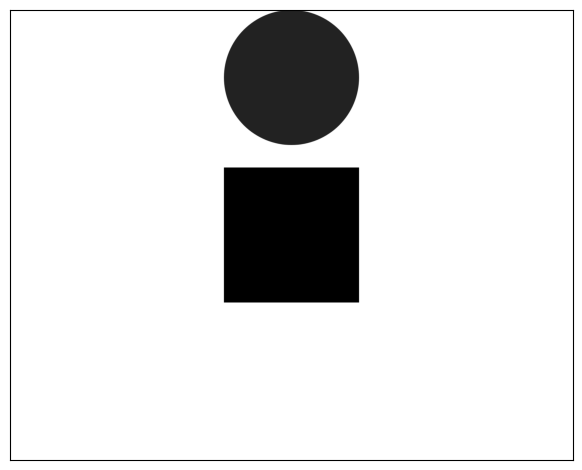

In [ ]:
plot(img1_batch)

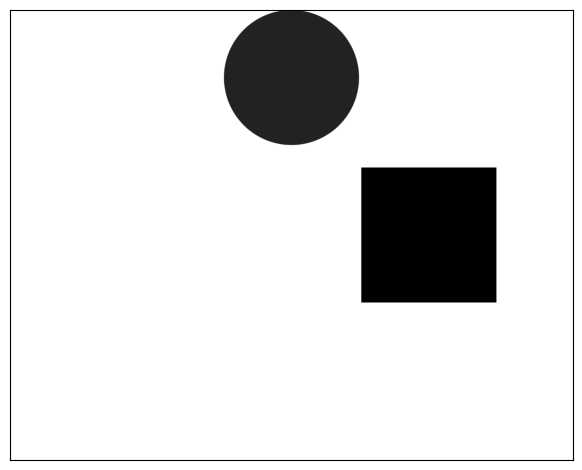

In [ ]:
plot(img2_batch)

The RAFT model accepts RGB images. We first get the frames from
:func:`~torchvision.io.read_video` and resize them to ensure their dimensions
are divisible by 8. Note that we explicitly use ``antialias=False``, because
this is how those models were trained. Then we use the transforms bundled into
the weights in order to preprocess the input and rescale its values to the
required ``[-1, 1]`` interval.



In [ ]:
tensor1.shape

torch.Size([4, 1600, 2000])

In [ ]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[200, 392], antialias=False)
    img2_batch = F.resize(img2_batch, size=[200, 392], antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([1, 3, 200, 392]), dtype = torch.float32


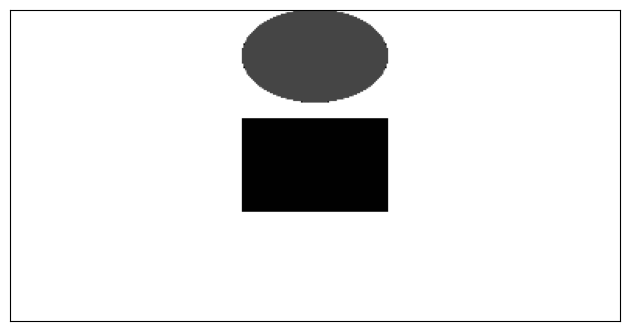

In [ ]:
plot(img1_batch)

## Estimating Optical flow using RAFT
We will use our RAFT implementation from
:func:`~torchvision.models.optical_flow.raft_large`, which follows the same
architecture as the one described in the [original paper](https://arxiv.org/abs/2003.12039).
We also provide the :func:`~torchvision.models.optical_flow.raft_small` model
builder, which is smaller and faster to run, sacrificing a bit of accuracy.



In [ ]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device =  "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


In [ ]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# print(device)

The RAFT model outputs lists of predicted flows where each entry is a
(N, 2, H, W) batch of predicted flows that corresponds to a given "iteration"
in the model. For more details on the iterative nature of the model, please
refer to the [original paper](https://arxiv.org/abs/2003.12039). Here, we
are only interested in the final predicted flows (they are the most acccurate
ones), so we will just retrieve the last item in the list.

As described above, a flow is a tensor with dimensions (2, H, W) (or (N, 2, H,
W) for batches of flows) where each entry corresponds to the horizontal and
vertical displacement of each pixel from the first image to the second image.
Note that the predicted flows are in "pixel" unit, they are not normalized
w.r.t. the dimensions of the images.



In [ ]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([1, 2, 200, 392]) = (N, 2, H, W)
min = -14.462202072143555, max = 102.79991912841797


## Visualizing predicted flows
Torchvision provides the :func:`~torchvision.utils.flow_to_image` utlity to
convert a flow into an RGB image. It also supports batches of flows.
each "direction" in the flow will be mapped to a given RGB color. In the
images below, pixels with similar colors are assumed by the model to be moving
in similar directions. The model is properly able to predict the movement of
the ball and the player. Note in particular the different predicted direction
of the ball in the first image (going to the left) and in the second image
(going up).



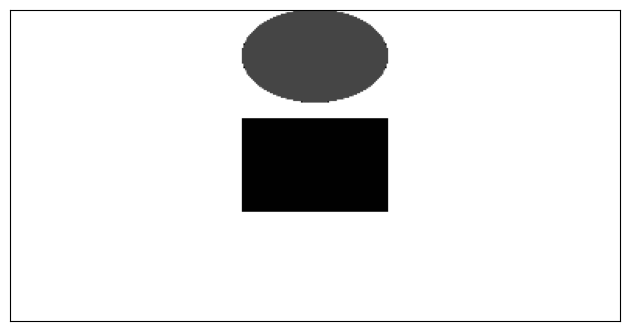

In [ ]:
plot(img1_batch)

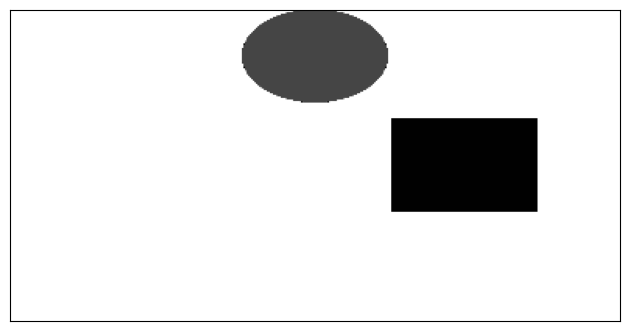

In [ ]:
plot(img2_batch)

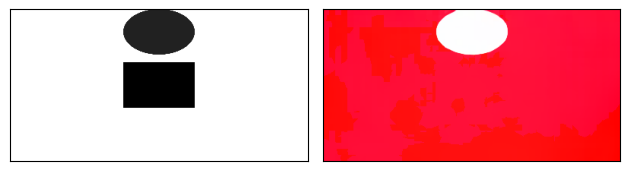

In [ ]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img_batch, flow_imgs)]
plot(grid)

In [ ]:
from raft_functions import *

In [ ]:
def remap_backward(image, flow):
    flow[np.isnan(flow)] = 0
    x = np.linspace(0, image.shape[1], image.shape[1])
    y = np.linspace(0, image.shape[0], image.shape[0])
    xv, yv = np.meshgrid(x,y)
    map_x = -flow[:, :, 0] + xv
    map_y = -flow[:, :, 1] + yv

    mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
    return mapped_img

(200, 392)


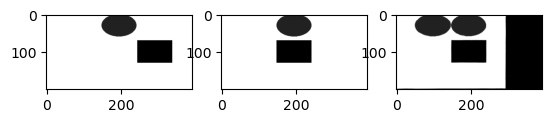

Structural similarity between the 2 images: 0.6629531511108375


In [ ]:
images1 = convert_images(img1_batch)
images2 = convert_images(img2_batch)
flows = convert_flow(predicted_flows)
mapped = remap_backward(images2[0], -flows[0])
print(flows[0,:,:,0].shape)
images1[0].shape
draw_process_evaluate(images2[0], images1[0], mapped)

In [5]:
def evaluate_raft_2(images1, images2, flows, remapping = 'forward'):

    similarity = []
    mapped = []
    if remapping == 'forward':
        for i in range(len(flows)):
            mapped.append(remap_forward(images1[i], flows[i][:,:,:]))
            # draw_process_evaluate(images1[i], images2[i], remap_forward(images1[i], flows[i][:,:,:]))
            # plt.imshow(draw_flow(images1[i][:,:,0], -flows[i][:,:,:], step=10)), plt.show()
            similarity.append([sm.structural_similarity(images2[i][: , :, 0], mapped[i][:, :, 0], data_range= 1)])
        
    else:
        for i in range(len(flows)):
            mapped.append(remap_backward(images2[i], flows[i][:,:,:]))
            draw_process_evaluate(images2[i], images1[i], remap_backward(images2[i], -flows[i][:,:,:]))
            plt.imshow(draw_flow(images2[i][:,:,0], -flows[i][:,:,:], step=10)), plt.show()
            similarity.append([sm.structural_similarity(images1[i][: , :, 0], mapped[i][:, :, 0], data_range=1)])
    

    return np.mean(similarity)

In [6]:
# from raft_functions import evaluate_raft
evaluation = evaluate_raft_2(images1, images2, flows, 'backward')
print(evaluation)

NameError: name 'images1' is not defined

In [7]:
import flowpy

flows[np.isnan(flows)] = 0
mapped = flowpy.backward_warp(images2[0], flows[0])
# print(flows[0,:,:,0].shape)
images1[0].shape
draw_process_evaluate(images2[0], images1[0], mapped)

NameError: name 'flows' is not defined